In [1]:
import random

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DQN, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecMonitor
from tqdm import tqdm
import torch
from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm

In [2]:
# render the agent demo
def render(env_name, model):
    vec_env = make_vec_env(env_name, n_envs=1)
    obs = vec_env.reset()

    for i in range(1000):
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        vec_env.render("human")

def plot_reward(episode_rewards, env_end_idx=None):
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label="Episode Reward")
    
    if env_end_idx:
        for x in env_end_idx:
            plt.axvline(x=x, color="red", linestyle="--")

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Episode Rewards")
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
# env_name = "Hopper-v5"
# log_file = "hopper"
# env = gym.make(env_name)
# env = Monitor(env, filename=log_file)
# model = PPO("MlpPolicy", env=env)
# model.learn(total_timesteps=50000)

In [ ]:

class TqdmProgressCallback(BaseCallback):
    def __init__(self, total_timesteps, verbose=0):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
        self.progress_bar = None
        self.last_update = 0

    def _on_training_start(self):
        self.progress_bar = tqdm(total=self.total_timesteps, desc="Training Progress", unit="steps")

    def _on_step(self) -> bool:
        delta_n = self.num_timesteps - self.last_update
        self.progress_bar.update(delta_n)
        self.last_update = self.num_timesteps
        return True

    def _on_training_end(self):
        self.progress_bar.close()


env_name = "Hopper-v5"
log_file = "hopper"
total_timesteps=1000000
progress_callback = TqdmProgressCallback(total_timesteps=total_timesteps)
env = make_vec_env(env_name, n_envs=8)
env = VecMonitor(env, filename=log_file)
model = PPO("MlpPolicy", env=env, verbose=False, policy_kwargs={"net_arch": [32, 32]})
model.learn(total_timesteps=total_timesteps, callback=progress_callback)

Training Progress:  29%|██▉       | 294912/1000000 [01:37<01:17, 9092.13steps/s]

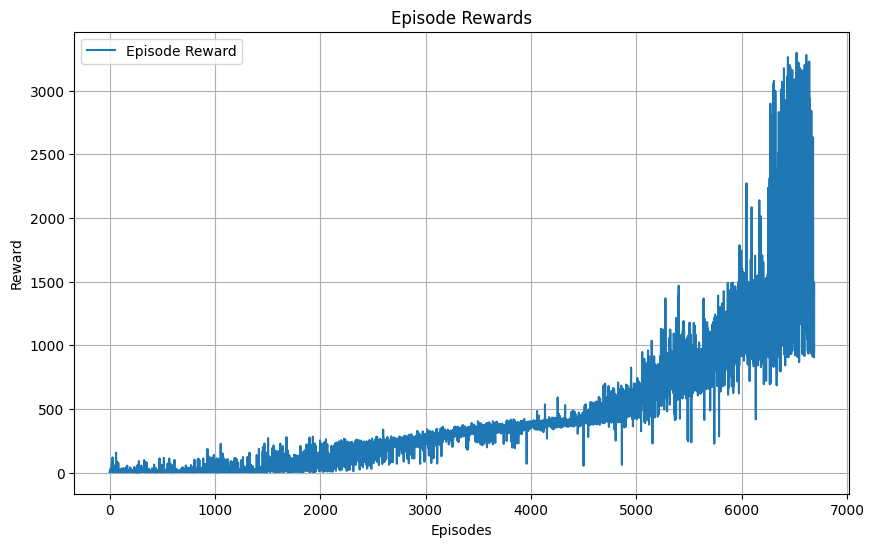

In [114]:
log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
plot_reward(log["r"])

In [ ]:
# render("Hopper-v5", model)

## Simulate physical changes

In [129]:
import torch

def create_env(log_file, random_mass=False):
    env = make_vec_env(
        "Hopper-v5",
        n_envs=8,
    )
    env = VecMonitor(env, filename=log_file)

    if random_mass:
        body_mass = [
            0., 
            random.uniform(2, 5),
            random.uniform(3, 6),
            random.uniform(2, 4),
            random.uniform(3, 6),
        ]
        gravity = random.uniform(-8, -10)
        print("setting", body_mass, gravity)
        for i in range(env.num_envs):
            # env.envs[i].unwrapped.model.body_mass = [0., 3.66519143, 4.05789051, 2.7813567 , 5.31557477]
            env.envs[i].unwrapped.model.body_mass = body_mass
            env.envs[i].unwrapped.model.opt.gravity = [0.0, 0.0, gravity]

    return env


def next_gravity(cur):
    while True:
        x = random.uniform(-4, -10)
        if abs(cur - x) >= 3:
            return x


log_file = "hopper"
episode_rewards = []
epoch_end_idx = []
env = create_env(log_file)
model = PPO(
    "MlpPolicy",
    env=env,
    verbose=False,
)

for _ in tqdm(range(10)):
    model.learn(total_timesteps=1000000)
    log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
    episode_rewards.extend(log["r"])
    epoch_end_idx.append(len(episode_rewards))

    env.close()
    env = create_env(log_file, random_mass=True)
    model.set_env(env)

model.save("ppo.model")


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 10%|█         | 1/10 [05:27<49:04, 327.16s/it]

setting [0.0, 4.573272925593237, 4.464671463194396, 2.8460324372751336, 3.1770614519262947] -8.27471582117208


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 20%|██        | 2/10 [10:57<43:54, 329.27s/it]

setting [0.0, 4.601512649405455, 4.576038374021497, 2.5954982256660073, 3.6956623221268017] -9.717297316306492


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 30%|███       | 3/10 [16:29<38:32, 330.36s/it]

setting [0.0, 2.1436941349268785, 5.411482552936645, 2.8689494251016185, 4.347742499455475] -9.671621167474184


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 40%|████      | 4/10 [21:47<32:31, 325.28s/it]

setting [0.0, 4.346116097714662, 4.396743895420633, 3.1847141149298963, 5.106736644388976] -9.421190198657778


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 50%|█████     | 5/10 [27:07<26:57, 323.52s/it]

setting [0.0, 3.900916118251247, 4.649365585225516, 2.9947237223574126, 3.6938153220756043] -8.903054352202744


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 60%|██████    | 6/10 [32:31<21:34, 323.64s/it]

setting [0.0, 4.67577045889796, 4.996579604165664, 3.7447166021425256, 5.6392656435492245] -9.975441012730728


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 70%|███████   | 7/10 [37:54<16:10, 323.58s/it]

setting [0.0, 4.969151968343187, 5.688587158905584, 2.058691043363983, 3.1832135517009776] -9.131460972880081


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 80%|████████  | 8/10 [43:19<10:48, 324.08s/it]

setting [0.0, 4.178501444083861, 3.6399852942212694, 3.0154308306126936, 5.892125176969318] -9.732329474370117


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 90%|█████████ | 9/10 [48:43<05:24, 324.04s/it]

setting [0.0, 2.81630675857149, 5.946974952629707, 2.889842070850503, 4.065265469741811] -8.474162027727887


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
100%|██████████| 10/10 [54:08<00:00, 324.89s/it]

setting [0.0, 4.972059998204276, 3.7495824751822884, 2.108046125757478, 5.7299074427465495] -8.176106165772921


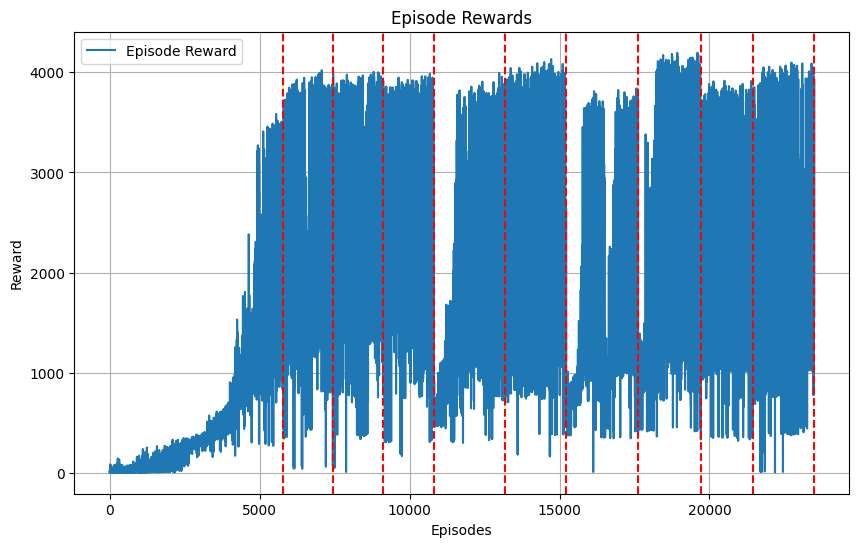

In [130]:
plot_reward(episode_rewards, epoch_end_idx)

In [ ]:
# env = make_vec_env(
#     "Hopper-v5",
#     n_envs=8,
# )
# for i in range(env.num_envs):
#     env.envs[i].unwrapped.model.body_mass = [0., 8.66519143, 1.05789051, 7.7813567 , 3.31557477]

# model.set_env(env)
# obs = env.reset()
# for i in range(1000):
#     action, _state = model.predict(obs, deterministic=True)
#     obs, reward, done, info = env.step(action)
#     env.render("human")

In [ ]:
# env = make_vec_env("Hopper-v5", n_envs=1)
# for i in range(env.num_envs):
#     env.envs[i].unwrapped.model.body_mass = [0., 8.66519143, 2.05789051, 2.7813567 , 5.31557477]

# m = model.load("ppo.model", env)
# obs = env.reset()

# for i in range(1000):
#     action, _state = m.predict(obs, deterministic=True)
#     obs, reward, done, info = env.step(action)
#     env.render("human")

## Action space change

In [ ]:
import torch

class ActionPermuteWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_size = 3
        self.permutation = list(range(self.action_size))

    def update_permutation(self):
        while True:
            new_permutation = torch.randperm(self.action_size).tolist()
            if new_permutation != self.permutation:
                self.permutation = new_permutation
                print("new action permutation:", self.permutation)
                break

    def step(self, action):
        action = torch.tensor(action)[self.permutation].tolist()
        return self.env.step(action)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ProgressCallback(BaseCallback):
    def __init__(self, total_timesteps, verbose=0):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
        self.progress_bar = None
        self.last_update = 0

    def _on_training_start(self):
        self.progress_bar = tqdm(total=self.total_timesteps, desc="Training Progress", unit="steps")

    def _on_step(self) -> bool:
        delta_n = self.num_timesteps - self.last_update
        self.progress_bar.update(delta_n)
        self.last_update = self.num_timesteps
        return True

    def _on_training_end(self):
        self.progress_bar.close()



log_file = "hopper"
env_name = "Hopper-v5"
env = gym.make(env_name)
env = Monitor(env, filename=log_file)
env = ActionPermuteWrapper(env)
model = PPO("MlpPolicy", env=env, verbose=False, policy_kwargs={"net_arch": [32, 32]})
episode_rewards = []
epoch_end_idx = []

for _ in tqdm(range(8)):
    model.learn(total_timesteps=1000000)
    log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
    epoch_end_idx.append(len(log["r"]))
    env.update_permutation()

model.save("ppo.model")

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [06:56<48:37, 416.74s/it]

new action permutation: [2, 1, 0]


 25%|██▌       | 2/8 [14:08<42:32, 425.34s/it]

new action permutation: [0, 1, 2]


 38%|███▊      | 3/8 [21:11<35:23, 424.68s/it]

new action permutation: [0, 2, 1]


 50%|█████     | 4/8 [28:12<28:11, 422.87s/it]

new action permutation: [2, 1, 0]


 62%|██████▎   | 5/8 [35:15<21:09, 423.04s/it]

new action permutation: [0, 1, 2]


 75%|███████▌  | 6/8 [42:13<14:02, 421.25s/it]

new action permutation: [0, 2, 1]


 88%|████████▊ | 7/8 [49:18<07:02, 422.49s/it]

new action permutation: [2, 1, 0]


100%|██████████| 8/8 [56:19<00:00, 422.39s/it]

new action permutation: [2, 0, 1]


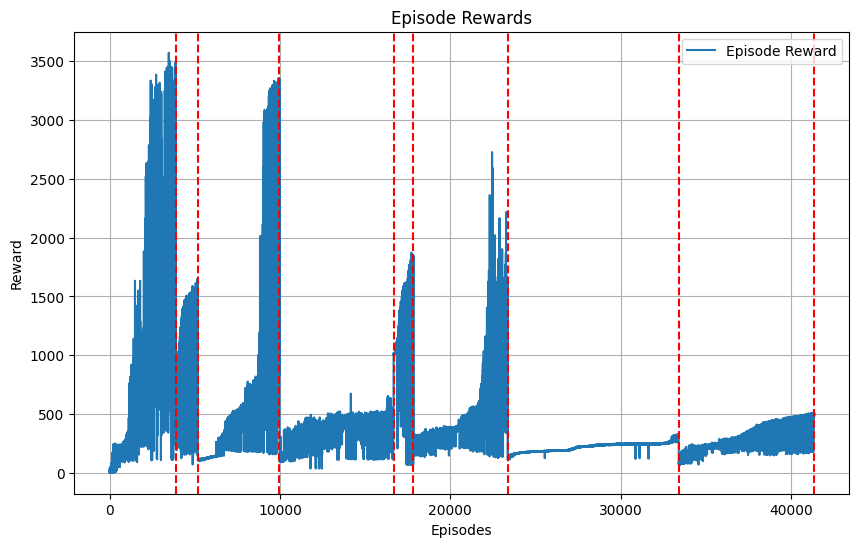

In [120]:
log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
plot_reward(log["r"], epoch_end_idx)
# plot_reward(log["r"])

In [121]:

import torch

class ActionPermuteWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_size = 3
        self.permutation = list(range(self.action_size))

    def update_permutation(self):
        while True:
            new_permutation = torch.randperm(self.action_size).tolist()
            if new_permutation != self.permutation:
                self.permutation = new_permutation
                print("new action permutation:", self.permutation)
                break

    def step(self, action):
        action = torch.tensor(action)[self.permutation].tolist()
        return self.env.step(action)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


log_file = "hopper-nochange"
env_name = "Hopper-v5"
env = gym.make(env_name)
env = Monitor(env, filename=log_file)
env = ActionPermuteWrapper(env)
model = PPO("MlpPolicy", env=env, verbose=False, policy_kwargs={"net_arch": [32, 32]})
episode_rewards = []
epoch_end_idx = []

for _ in tqdm(range(8)):
    model.learn(total_timesteps=1000000)
    log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
    epoch_end_idx.append(len(log["r"]))
    # env.update_permutation()

model.save("ppo.model")

100%|██████████| 8/8 [55:39<00:00, 417.45s/it]


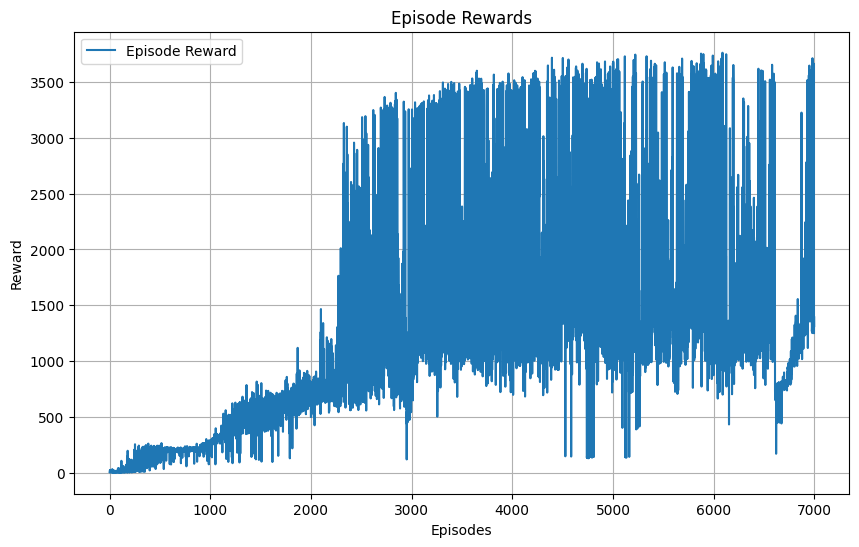

In [126]:
log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
plot_reward(log["r"])

## Action space change 2

In [3]:
class ActionPermuteWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_size = 3
        self.permutation = list(range(self.action_size))

    def update_permutation(self):
        while True:
            new_permutation = torch.randperm(self.action_size).tolist()
            if new_permutation != self.permutation:
                self.permutation = new_permutation
                print("new action permutation:", self.permutation)
                break

    def step(self, action):
        action = torch.tensor(action)[self.permutation].tolist()
        return self.env.step(action)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ActionChangeCallback(BaseCallback):
    def __init__(self, total_timesteps, change_interval=None, verbose=0):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
        self.progress_bar = None
        self.last_update = 0
        self.change_interval = change_interval

    def _on_training_start(self):
        self.progress_bar = tqdm(
            total=self.total_timesteps, desc="Training Progress", unit="steps"
        )

    def _on_step(self) -> bool:
        delta_n = self.num_timesteps - self.last_update

        # if delta_n > 100:
        self.progress_bar.update(delta_n)
        self.last_update = self.num_timesteps

        if (
            self.change_interval
            and self.num_timesteps != 0
            and self.num_timesteps % self.change_interval == 0
        ):
            self.training_env.envs[0].update_permutation()

        return True

    def _on_training_end(self):
        self.progress_bar.close()


log_file = "hopper"
env_name = "Hopper-v5"
total_timesteps = 10 * 2000000
change_interval = 2000000
env = gym.make(env_name)
env = Monitor(env, filename=log_file)
env = ActionPermuteWrapper(env)

model = PPO("MlpPolicy", env=env, verbose=False)
cb = ActionChangeCallback(
    total_timesteps=total_timesteps, change_interval=change_interval
)
model.learn(total_timesteps=total_timesteps, callback=cb)

Training Progress:  10%|█         | 2000753/20000000 [1:15:34<1:40:44, 2977.89steps/s] 

new action permutation: [1, 2, 0]


Training Progress:  20%|██        | 4000247/20000000 [2:03:08<2:36:41, 1701.76steps/s] 

new action permutation: [2, 1, 0]


Training Progress:  30%|███       | 6000536/20000000 [2:20:35<1:19:59, 2917.06steps/s]

new action permutation: [1, 2, 0]


Training Progress:  40%|████      | 8000296/20000000 [2:38:58<1:57:48, 1697.53steps/s]

new action permutation: [1, 0, 2]


Training Progress:  50%|█████     | 10000061/20000000 [4:08:07<57:08, 2916.62steps/s]   

new action permutation: [2, 1, 0]


Training Progress:  60%|██████    | 12000419/20000000 [4:24:57<55:36, 2397.78steps/s]  

new action permutation: [0, 2, 1]


Training Progress:  70%|███████   | 14000101/20000000 [4:43:34<34:28, 2900.20steps/s]  

new action permutation: [2, 0, 1]


Training Progress:  80%|████████  | 16000496/20000000 [5:02:59<27:28, 2426.57steps/s]  

new action permutation: [0, 2, 1]


Training Progress:  90%|█████████ | 18000494/20000000 [7:44:24<16:33, 2012.78steps/s]   

new action permutation: [0, 1, 2]


Training Progress: 20000551steps [8:17:07, 2769.76steps/s]                             

new action permutation: [1, 2, 0]


Training Progress: 20000768steps [8:17:07, 670.54steps/s] 


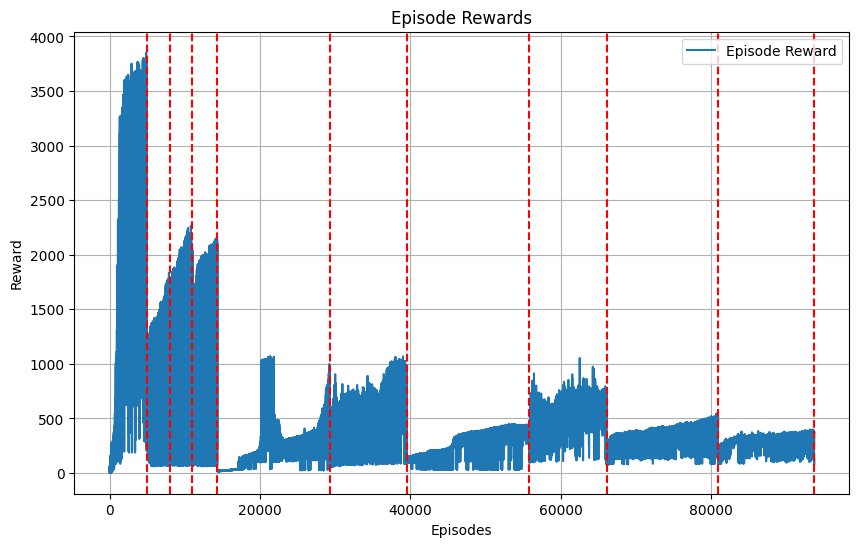

In [8]:
log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments

length = log["l"]
change_ep_index = []
acc = 0
for i, n in enumerate(length):
    acc += n
    if acc > change_interval:
        acc = 0
        change_ep_index.append(i)

plot_reward(log["r"], change_ep_index)